### LOAD & PRE-PROCESS DATA

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load splits
df_train = pd.read_csv("../data/cache/poster3_train_graphed.csv")
df_val = pd.read_csv("../data/cache/poster3_val_graphed.csv")
df_test = pd.read_csv("../data/cache/poster3_test.csv")

# Helper: safely split strings into lists
def split_tags(col):
    return col.fillna("").apply(lambda x: [t.strip() for t in x.split(",") if t.strip()])

# Step 1: Build the set of all genres and subgenres for dummy encoding
df_combined = pd.concat([df_train, df_val], ignore_index=True)

all_genres = sorted({tag for tags in split_tags(df_combined["genres"]) for tag in tags})
all_subgenres = sorted({tag for tags in split_tags(df_combined["subgenres"]) for tag in tags})

# Choose reference classes
genre_reference = "Drama"
subgenre_reference = "period-drama"

# Step 2: Define function to dummy encode
def dummy_encode_tags(col, all_tags, reference_tag):
    dummy_df = col.apply(lambda tags: pd.Series({tag: int(tag in tags) for tag in all_tags}))
    dummy_df = dummy_df.drop(columns=[reference_tag])  # Drop reference category
    dummy_df = dummy_df.add_prefix(f"{col.name}_")
    return dummy_df

# Step 3: Function to process each split
def process_split(df):
    df = df[df["from_budget_category"] != "indie"].reset_index(drop=True)
    
    genres = dummy_encode_tags(split_tags(df["genres"]), all_genres, genre_reference)
    subgenres = dummy_encode_tags(split_tags(df["subgenres"]), all_subgenres, subgenre_reference)
    
    numeric = df[["from_runtimeMinutes", "from_budget_adj"]].reset_index(drop=True)

    X = pd.concat([numeric, genres, subgenres], axis=1)

    # Also append the dummy columns to the original df
    df = df.reset_index(drop=True)
    df = pd.concat([df, genres, subgenres], axis=1)

    return X, df

# Step 4: Process each split
X_train_raw, df_train_filtered = process_split(df_train)
X_val_raw, df_val_filtered = process_split(df_val)
X_test_raw, df_test_filtered = process_split(df_test)

# Step 5: Create target variables

# y1: raw profit
y1_train = df_train_filtered["profit"].reset_index(drop=True)
y1_val = df_val_filtered["profit"].reset_index(drop=True)
y1_test = df_test_filtered["profit"].reset_index(drop=True)

# Clip profit at -0.99 before log1p
profit_train = df_train_filtered["profit"].clip(lower=-0.99)
profit_val = df_val_filtered["profit"].clip(lower=-0.99)
profit_test = df_test_filtered["profit"].clip(lower=-0.99)

# y2: log(1 + profit)
y2_train = np.log1p(profit_train).reset_index(drop=True)
y2_val = np.log1p(profit_val).reset_index(drop=True)
y2_test = np.log1p(profit_test).reset_index(drop=True)

# y3: ROI
roi_train = df_train_filtered["profit"] / df_train_filtered["from_budget_adj"]
roi_val = df_val_filtered["profit"] / df_val_filtered["from_budget_adj"]
roi_test = df_test_filtered["profit"] / df_test_filtered["from_budget_adj"]

# Clip ROI at -0.99 before log1p
roi_train = roi_train.clip(lower=-0.99)
roi_val = roi_val.clip(lower=-0.99)
roi_test = roi_test.clip(lower=-0.99)

y3_train = roi_train.reset_index(drop=True)
y3_val = roi_val.reset_index(drop=True)
y3_test = roi_test.reset_index(drop=True)

# y4: log(1 + ROI)
y4_train = np.log1p(roi_train).reset_index(drop=True)
y4_val = np.log1p(roi_val).reset_index(drop=True)
y4_test = np.log1p(roi_test).reset_index(drop=True)

# Step 6: Scale all features based on training stats
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_val = scaler.transform(X_val_raw)
X_test = scaler.transform(X_test_raw)

print("Datasets locked and loaded!")


Datasets locked and loaded!


In [39]:
df_combined.columns

Index(['Unnamed: 0', 'from_tconst', 'from_label', 'from_title', 'from_year',
       'from_runtimeMinutes', 'from_averageRating', 'from_numVotes',
       'from_budget', 'from_revenue', 'relationship', 'to_label', 'to_name',
       'to_id', 'to_gender', 'to_popularity', 'to_adult', 'genres',
       'subgenres', 'from_year_adj', 'from_budget_adj', 'from_revenue_adj',
       'from_budget_category', 'profit', 'profit_percent_gain',
       'm.betweenness_m2m', 'm.degree', 'm.community_id', 'm.community_size'],
      dtype='object')

### 5-FOLD CROSS VALIDATION

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Bundle all targets together
target_sets = {
    "Profit (y1)": y1_train,
    "Log(Profit) (y2)": y2_train,
    "ROI (y3)": y3_train,
    "Log(ROI) (y4)": y4_train
}

# To store results
results = {}

for label, y_target in target_sets.items():
    mae_scores = []
    rmse_scores = []
    r2_scores = []

    for train_idx, val_idx in kf.split(X_train):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_target.iloc[train_idx], y_target.iloc[val_idx]

        model = LinearRegression()
        model.fit(X_fold_train, y_fold_train)

        y_pred = model.predict(X_fold_val)

        mae = mean_absolute_error(y_fold_val, y_pred)
        rmse = mean_squared_error(y_fold_val, y_pred, squared=False)
        r2 = r2_score(y_fold_val, y_pred)

        mae_scores.append(mae)
        rmse_scores.append(rmse)
        r2_scores.append(r2)

    results[label] = {
        "MAE": np.mean(mae_scores),
        "RMSE": np.mean(rmse_scores),
        "R²": np.mean(r2_scores)
    }

# Print results
for label, metrics in results.items():
    print(f"\n{label}")
    print(f"  Mean MAE:  {metrics['MAE']:.4f}")
    print(f"  Mean RMSE: {metrics['RMSE']:.4f}")
    print(f"  Mean R²:   {metrics['R²']:.4f}")


Profit (y1)
  Mean MAE:  138492065.0252
  Mean RMSE: 238826742.5414
  Mean R²:   0.2685

Log(Profit) (y2)
  Mean MAE:  8.4198
  Mean RMSE: 9.9123
  Mean R²:   0.0501

ROI (y3)
  Mean MAE:  3.3939
  Mean RMSE: 7.3037
  Mean R²:   0.0089

Log(ROI) (y4)
  Mean MAE:  0.9150
  Mean RMSE: 1.1818
  Mean R²:   0.0705


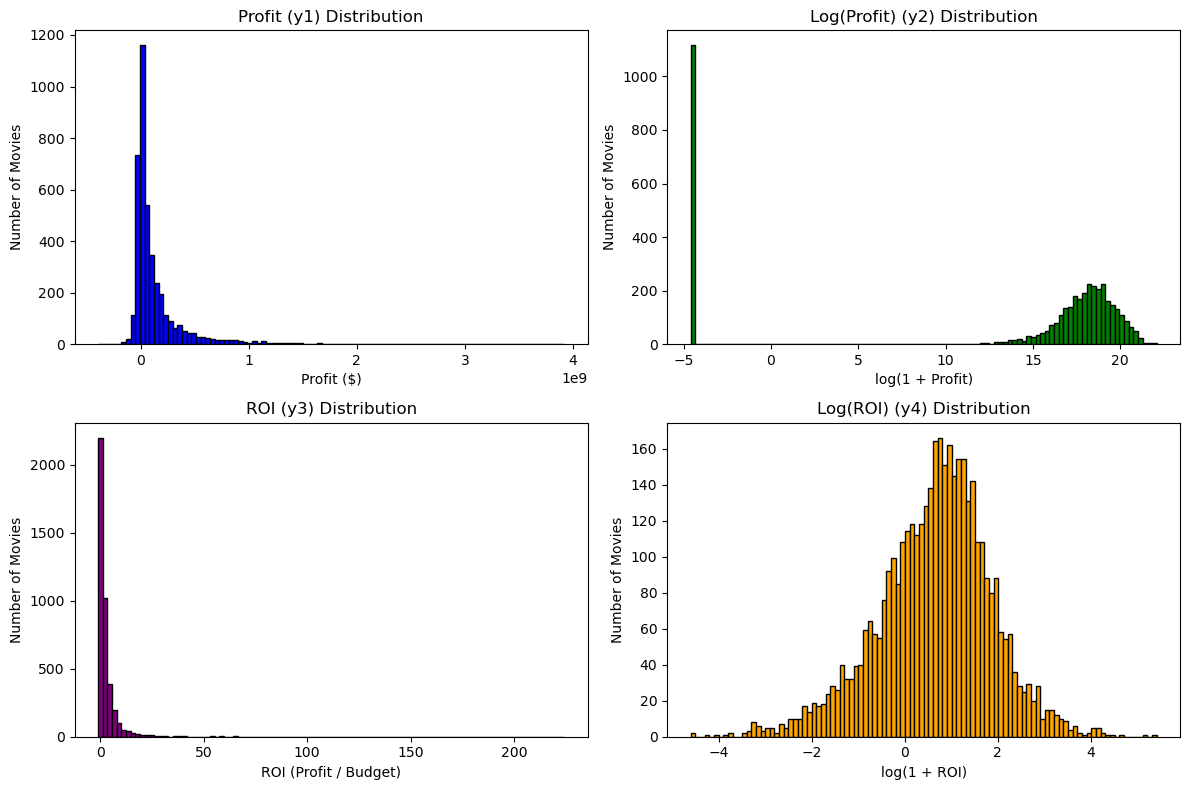

In [3]:
import matplotlib.pyplot as plt

# Set up figure
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Profit (raw)
axs[0, 0].hist(y1_train, bins=100, color='blue', edgecolor='black')
axs[0, 0].set_title("Profit (y1) Distribution")
axs[0, 0].set_xlabel("Profit ($)")
axs[0, 0].set_ylabel("Number of Movies")

# Log(Profit)
axs[0, 1].hist(y2_train, bins=100, color='green', edgecolor='black')
axs[0, 1].set_title("Log(Profit) (y2) Distribution")
axs[0, 1].set_xlabel("log(1 + Profit)")
axs[0, 1].set_ylabel("Number of Movies")

# ROI (raw)
axs[1, 0].hist(y3_train, bins=100, color='purple', edgecolor='black')
axs[1, 0].set_title("ROI (y3) Distribution")
axs[1, 0].set_xlabel("ROI (Profit / Budget)")
axs[1, 0].set_ylabel("Number of Movies")

# Log(ROI)
axs[1, 1].hist(y4_train, bins=100, color='orange', edgecolor='black')
axs[1, 1].set_title("Log(ROI) (y4) Distribution")
axs[1, 1].set_xlabel("log(1 + ROI)")
axs[1, 1].set_ylabel("Number of Movies")

plt.tight_layout()
plt.show()


### RANDOM FOREST

In [4]:
from sklearn.ensemble import RandomForestRegressor

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# To store results
mae_scores = []
rmse_scores = []
r2_scores = []

for train_idx, val_idx in kf.split(X_train):
    X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
    y_fold_train, y_fold_val = y1_train.iloc[train_idx], y1_train.iloc[val_idx]

    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        random_state=42,
        n_jobs=-1  # Use all cores
    )
    model.fit(X_fold_train, y_fold_train)

    y_pred = model.predict(X_fold_val)

    mae = mean_absolute_error(y_fold_val, y_pred)
    rmse = mean_squared_error(y_fold_val, y_pred, squared=False)
    r2 = r2_score(y_fold_val, y_pred)

    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

print("\nRandom Forest 5-Fold CV Results:")
print(f"  Mean MAE:  ${np.mean(mae_scores):,.2f}")
print(f"  Mean RMSE: ${np.mean(rmse_scores):,.2f}")
print(f"  Mean R²:   {np.mean(r2_scores):.4f}")



Random Forest 5-Fold CV Results:
  Mean MAE:  $128,459,966.86
  Mean RMSE: $237,258,685.16
  Mean R²:   0.2776


### FMM (CONTINUOUS BUDGET)

In [5]:
from sklearn.mixture import GaussianMixture

# Step 1: Combine train + val
X_train_val = np.vstack([X_train, X_val])
y_train_val = pd.concat([y1_train, y1_val]).reset_index(drop=True)

print("Combined training and validation sets!")

# Step 3: Fit GMM
k = 20  # Number of clusters

gmm = GaussianMixture(n_components=k, random_state=42, covariance_type='full')
gmm.fit(X_train_val)

# Predict cluster labels for each movie
train_val_clusters = gmm.predict(X_train_val)

print(f"FMM fitted with {k} clusters!")

# Create a DataFrame for train+val movies
df_train_val_clusters = pd.DataFrame({
    "profit": y_train_val,
    "cluster": train_val_clusters
})

print("Cluster assignments complete!")


Combined training and validation sets!
FMM fitted with 20 clusters!
Cluster assignments complete!


In [6]:
import numpy as np
from scipy.stats import t

# Step 5: Compute statistics per cluster
cluster_stats = {}

for cluster_id in sorted(df_train_val_clusters["cluster"].unique()):
    profits = df_train_val_clusters[df_train_val_clusters["cluster"] == cluster_id]["profit"]

    mean_profit = profits.mean()
    std_profit = profits.std(ddof=1)
    n = len(profits)

    if n > 1:
        ci_low, ci_high = t.interval(
            confidence=0.95,
            df=n-1,
            loc=mean_profit,
            scale=std_profit / np.sqrt(n)
        )
    else:
        ci_low, ci_high = (np.nan, np.nan)

    cluster_stats[cluster_id] = {
        "n_movies": n,
        "mean_profit": mean_profit,
        "std_profit": std_profit,
        "profit_ci": (ci_low, ci_high)
    }

print("Cluster statistics calculated!")

Cluster statistics calculated!


In [7]:
# Step 6: Predict clusters and profits for test set
test_clusters = gmm.predict(X_test)

# Prepare a list to store results
test_predictions = []

for idx, cluster_id in enumerate(test_clusters):
    stats = cluster_stats.get(cluster_id, None)
    if stats is not None:
        pred_profit = stats["mean_profit"]
        ci = stats["profit_ci"]
    else:
        pred_profit = np.nan
        ci = (np.nan, np.nan)

    test_predictions.append({
        "test_index": idx,
        "assigned_cluster": cluster_id,
        "predicted_profit": pred_profit,
        "profit_ci_low": ci[0],
        "profit_ci_high": ci[1]
    })

# Convert to DataFrame
df_test_predictions = pd.DataFrame(test_predictions)

print("Test set predictions complete!")

Test set predictions complete!


In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Actual profits from test set
actual_profits = y1_test.reset_index(drop=True)

# Add actual profits to prediction dataframe
df_test_predictions["actual_profit"] = actual_profits

# Compute evaluation metrics
mae = mean_absolute_error(df_test_predictions["actual_profit"], df_test_predictions["predicted_profit"])
rmse = mean_squared_error(df_test_predictions["actual_profit"], df_test_predictions["predicted_profit"], squared=False)
r2 = r2_score(df_test_predictions["actual_profit"], df_test_predictions["predicted_profit"])

print("\nFMM Test Set Evaluation:")
print(f"  MAE:  ${mae:,.2f}")
print(f"  RMSE: ${rmse:,.2f}")
print(f"  R²:   {r2:.4f}")

# (Optional) Check CI coverage
def falls_in_ci(row):
    if pd.isnull(row["profit_ci_low"]) or pd.isnull(row["profit_ci_high"]):
        return False
    return row["profit_ci_low"] <= row["actual_profit"] <= row["profit_ci_high"]

ci_coverage = df_test_predictions.apply(falls_in_ci, axis=1).mean()
print(f"  CI Coverage Rate: {ci_coverage:.2%}")



FMM Test Set Evaluation:
  MAE:  $155,327,499.60
  RMSE: $248,644,841.96
  R²:   -0.0658
  CI Coverage Rate: 6.06%


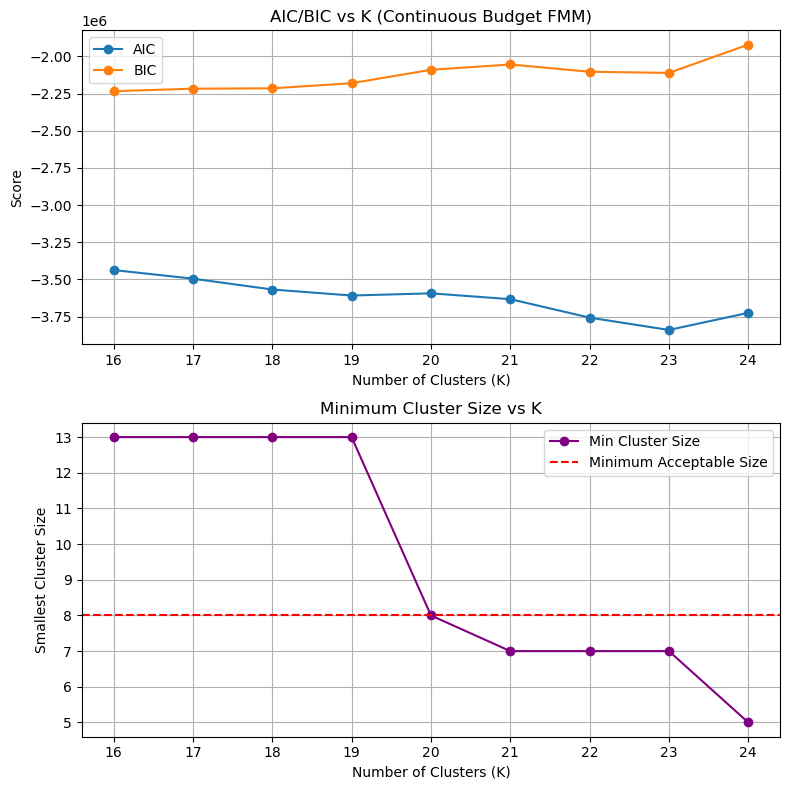

In [9]:
# TUNE K

import matplotlib.pyplot as plt
from collections import Counter

# Combine train+val
X_train_val_combined = np.vstack([X_train, X_val])

# Sweep K values
k_values = [16, 17, 18, 19, 20, 21, 22, 23, 24]
aic_scores = []
bic_scores = []
min_cluster_sizes = []

for k in k_values:
    gmm = GaussianMixture(n_components=k, random_state=42, covariance_type="full")
    gmm.fit(X_train_val_combined)
    
    preds = gmm.predict(X_train_val_combined)
    cluster_sizes = Counter(preds)
    min_size = min(cluster_sizes.values())
    
    aic_scores.append(gmm.aic(X_train_val_combined))
    bic_scores.append(gmm.bic(X_train_val_combined))
    min_cluster_sizes.append(min_size)

# Plot AIC/BIC and Min Cluster Size
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

# AIC and BIC plot
axs[0].plot(k_values, aic_scores, label="AIC", marker='o')
axs[0].plot(k_values, bic_scores, label="BIC", marker='o')
axs[0].set_xlabel("Number of Clusters (K)")
axs[0].set_ylabel("Score")
axs[0].set_title("AIC/BIC vs K (Continuous Budget FMM)")
axs[0].legend()
axs[0].grid(True)

# Min Cluster Size plot
axs[1].plot(k_values, min_cluster_sizes, label="Min Cluster Size", marker='o', color='purple')
axs[1].axhline(y=8, color='red', linestyle='--', label="Minimum Acceptable Size")
axs[1].set_xlabel("Number of Clusters (K)")
axs[1].set_ylabel("Smallest Cluster Size")
axs[1].set_title("Minimum Cluster Size vs K")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

### FMM (DISCRITIZED BUDGETS)

In [10]:
import warnings
warnings.filterwarnings("ignore", message=".*memory leak on Windows with MKL.*")

# Step 1: Combine full train+val dataframes for tier filtering
df_train_val_filtered = pd.concat([df_train_filtered, df_val_filtered], ignore_index=True)

# Build tier masks
budget_tiers = sorted(df_train_val_filtered["from_budget_category"].unique())

X_train_val_by_tier = {}
y_train_val_by_tier = {}

for tier in budget_tiers:
    tier_mask = (df_train_val_filtered["from_budget_category"] == tier)
    X_train_val_by_tier[tier] = X_train_val[tier_mask.values]
    y_train_val_by_tier[tier] = pd.concat([y1_train, y1_val], ignore_index=True)[tier_mask.values]

print("Splits by budget tier complete!")

from sklearn.mixture import GaussianMixture

# Store GMMs
gmm_by_tier = {}

k_per_tier = {
    "low": 15,
    "medium": 20,
    "high": 15,
    "tentpole": 12
}

for tier in budget_tiers:
    X_tier = X_train_val_by_tier[tier]
    k = k_per_tier[tier]
    
    gmm = GaussianMixture(n_components=k, random_state=42, covariance_type="full")
    gmm.fit(X_tier)
    
    gmm_by_tier[tier] = gmm

print("GMMs trained per budget tier!")


Splits by budget tier complete!
GMMs trained per budget tier!


In [11]:
# Step 3: Assign test movies to tier + cluster
test_predictions_tiered = []

for idx, row in df_test_filtered.reset_index(drop=True).iterrows():
    # Get test movie's budget tier
    tier = row["from_budget_category"]

    # Get matching GMM
    gmm = gmm_by_tier.get(tier, None)

    if gmm is None:
        # Skip if no GMM for tier
        pred_profit = np.nan
        cluster_id = np.nan
        ci = (np.nan, np.nan)
    else:
        # Get features for prediction
        x = X_test[idx].reshape(1, -1)

        # Predict cluster
        cluster_id = gmm.predict(x)[0]

        # Find matching cluster in train+val
        X_tier = X_train_val_by_tier[tier]
        y_tier = y_train_val_by_tier[tier]

        cluster_assignments = gmm.predict(X_tier)
        mask = (cluster_assignments == cluster_id)

        profits = y_tier[mask]

        if len(profits) > 1:
            mean_profit = profits.mean()
            std_profit = profits.std(ddof=1)
            from scipy.stats import t
            ci_low, ci_high = t.interval(
                confidence=0.95,
                df=len(profits) - 1,
                loc=mean_profit,
                scale=std_profit / np.sqrt(len(profits))
            )
        else:
            mean_profit = np.nan
            ci_low, ci_high = (np.nan, np.nan)

        pred_profit = mean_profit
        ci = (ci_low, ci_high)

    test_predictions_tiered.append({
        "test_index": idx,
        "budget_tier": tier,
        "assigned_cluster": cluster_id,
        "predicted_profit": pred_profit,
        "profit_ci_low": ci[0],
        "profit_ci_high": ci[1]
    })

# Convert to DataFrame
df_test_predictions_tiered = pd.DataFrame(test_predictions_tiered)

print("Test set assignment + prediction for budget-tiered FMM complete!")


Test set assignment + prediction for budget-tiered FMM complete!


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Add actual profits to prediction dataframe
df_test_predictions_tiered["actual_profit"] = y1_test.reset_index(drop=True)

# Compute evaluation metrics
mae_tiered = mean_absolute_error(df_test_predictions_tiered["actual_profit"], df_test_predictions_tiered["predicted_profit"])
rmse_tiered = mean_squared_error(df_test_predictions_tiered["actual_profit"], df_test_predictions_tiered["predicted_profit"], squared=False)
r2_tiered = r2_score(df_test_predictions_tiered["actual_profit"], df_test_predictions_tiered["predicted_profit"])

print("\nTiered FMM Test Set Evaluation:")
print(f"  MAE:  ${mae_tiered:,.2f}")
print(f"  RMSE: ${rmse_tiered:,.2f}")
print(f"  R²:   {r2_tiered:.4f}")

# Confidence interval coverage
def falls_in_ci_tiered(row):
    if pd.isnull(row["profit_ci_low"]) or pd.isnull(row["profit_ci_high"]):
        return False
    return row["profit_ci_low"] <= row["actual_profit"] <= row["profit_ci_high"]

ci_coverage_tiered = df_test_predictions_tiered.apply(falls_in_ci_tiered, axis=1).mean()
print(f"  CI Coverage Rate: {ci_coverage_tiered:.2%}")



Tiered FMM Test Set Evaluation:
  MAE:  $157,706,984.72
  RMSE: $242,336,409.44
  R²:   -0.0124
  CI Coverage Rate: 14.72%



=== Tuning High Budget Tier ===


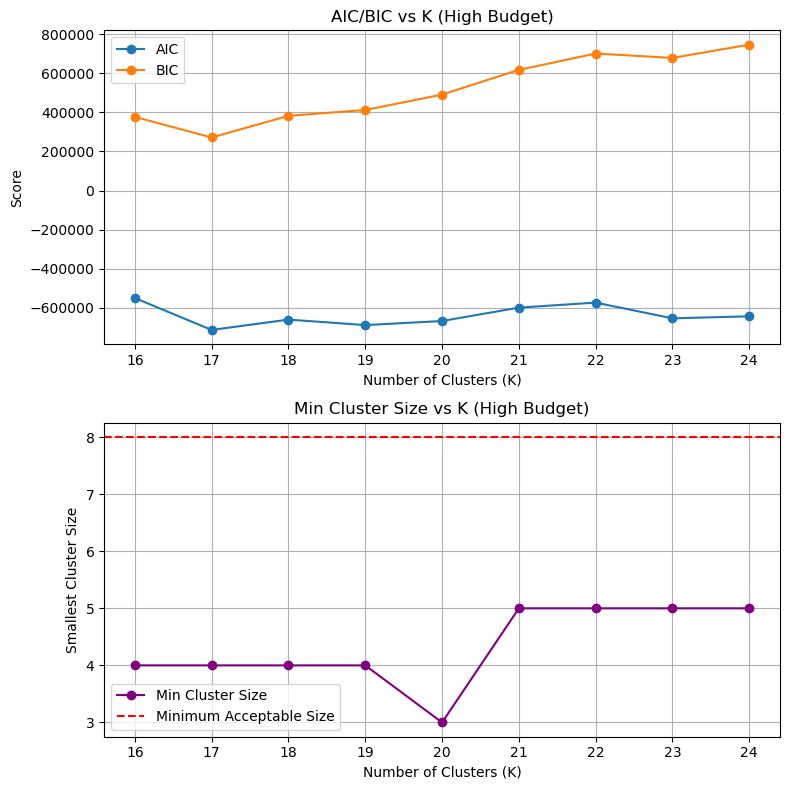


=== Tuning Low Budget Tier ===


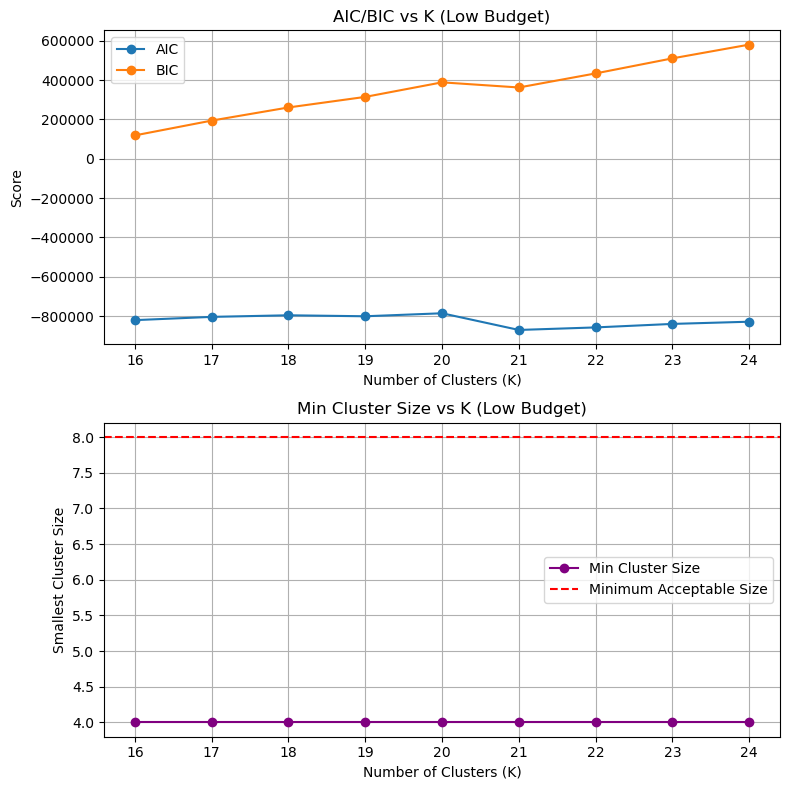


=== Tuning Medium Budget Tier ===


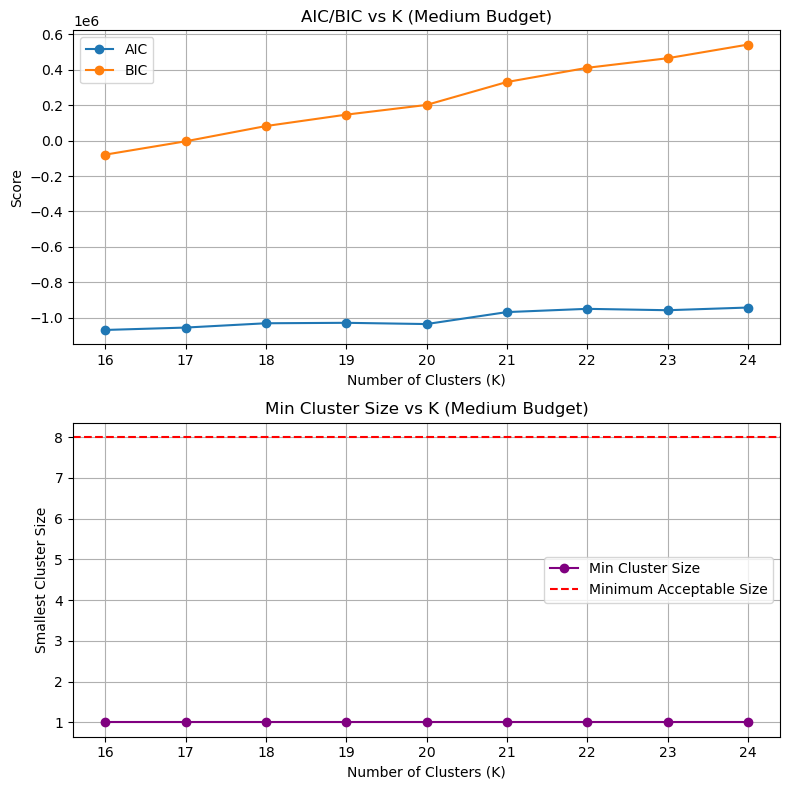


=== Tuning Tentpole Budget Tier ===


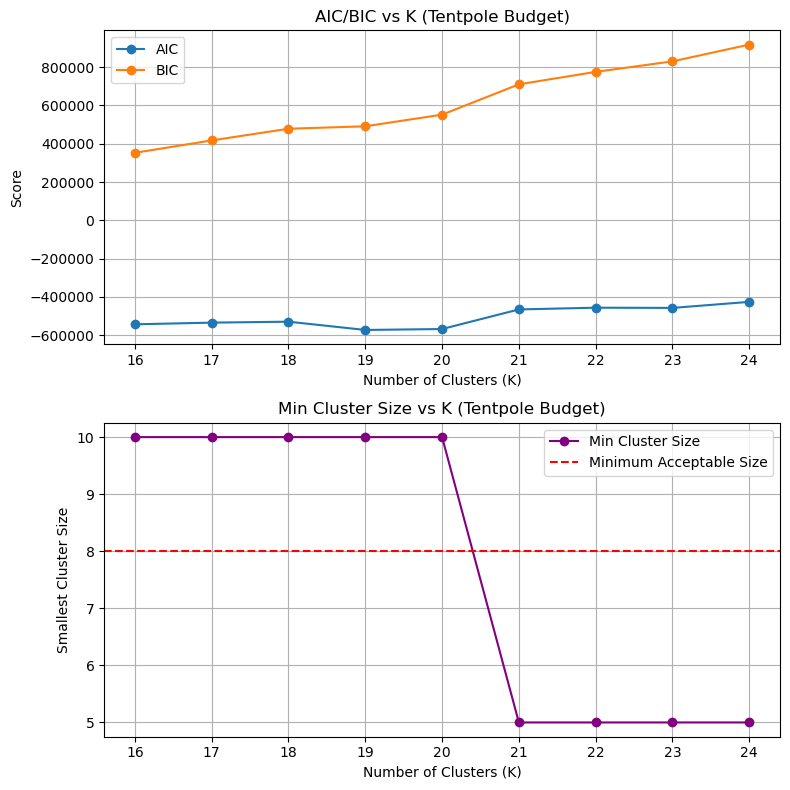

In [13]:
# TUNE K

import matplotlib.pyplot as plt
from collections import Counter
from sklearn.mixture import GaussianMixture

# Settings
k_values = [16, 17, 18, 19, 20, 21, 22, 23, 24]
tier_results = {}

for tier in budget_tiers:
    print(f"\n=== Tuning {tier.title()} Budget Tier ===")
    X_tier = X_train_val_by_tier[tier]

    aic_scores = []
    bic_scores = []
    min_cluster_sizes = []

    for k in k_values:
        gmm = GaussianMixture(n_components=k, random_state=42, covariance_type="full")
        gmm.fit(X_tier)

        preds = gmm.predict(X_tier)
        cluster_sizes = Counter(preds)
        min_size = min(cluster_sizes.values())

        aic_scores.append(gmm.aic(X_tier))
        bic_scores.append(gmm.bic(X_tier))
        min_cluster_sizes.append(min_size)

    # Save results
    tier_results[tier] = {
        "k_values": k_values,
        "aic": aic_scores,
        "bic": bic_scores,
        "min_cluster_sizes": min_cluster_sizes
    }

    # Plot for this tier
    fig, axs = plt.subplots(2, 1, figsize=(8, 8))

    # AIC/BIC plot
    axs[0].plot(k_values, aic_scores, label="AIC", marker='o')
    axs[0].plot(k_values, bic_scores, label="BIC", marker='o')
    axs[0].set_title(f"AIC/BIC vs K ({tier.title()} Budget)")
    axs[0].set_xlabel("Number of Clusters (K)")
    axs[0].set_ylabel("Score")
    axs[0].legend()
    axs[0].grid(True)

    # Min cluster size plot
    axs[1].plot(k_values, min_cluster_sizes, label="Min Cluster Size", marker='o', color='purple')
    axs[1].axhline(y=8, color='red', linestyle='--', label="Minimum Acceptable Size")
    axs[1].set_title(f"Min Cluster Size vs K ({tier.title()} Budget)")
    axs[1].set_xlabel("Number of Clusters (K)")
    axs[1].set_ylabel("Smallest Cluster Size")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


In [14]:
# Step: Refit GMMs with new best K values per tier
best_k_per_tier = {
    "low": 20,
    "medium": 25,
    "high": 23,
    "tentpole": 20
}

# Store updated GMMs
gmm_by_tier_bestk = {}

for tier in budget_tiers:
    X_tier = X_train_val_by_tier[tier]
    k = best_k_per_tier[tier]
    
    gmm = GaussianMixture(n_components=k, random_state=42, covariance_type="full")
    gmm.fit(X_tier)
    
    gmm_by_tier_bestk[tier] = gmm

print("Tiered GMMs retrained with best K values!")


Tiered GMMs retrained with best K values!


In [15]:
# Step: Assign test movies to new tuned Tiered FMMs
test_predictions_tiered_bestk = []

for idx, row in df_test_filtered.reset_index(drop=True).iterrows():
    tier = row["from_budget_category"]
    gmm = gmm_by_tier_bestk.get(tier, None)

    if gmm is None:
        pred_profit = np.nan
        cluster_id = np.nan
        ci = (np.nan, np.nan)
    else:
        x = X_test[idx].reshape(1, -1)
        cluster_id = gmm.predict(x)[0]

        X_tier = X_train_val_by_tier[tier]
        y_tier = y_train_val_by_tier[tier]

        cluster_assignments = gmm.predict(X_tier)
        mask = (cluster_assignments == cluster_id)

        profits = y_tier[mask]

        if len(profits) > 1:
            from scipy.stats import t
            mean_profit = profits.mean()
            std_profit = profits.std(ddof=1)
            ci_low, ci_high = t.interval(
                confidence=0.95,
                df=len(profits) - 1,
                loc=mean_profit,
                scale=std_profit / np.sqrt(len(profits))
            )
        else:
            mean_profit = np.nan
            ci_low, ci_high = (np.nan, np.nan)

        pred_profit = mean_profit
        ci = (ci_low, ci_high)

    test_predictions_tiered_bestk.append({
        "test_index": idx,
        "budget_tier": tier,
        "assigned_cluster": cluster_id,
        "predicted_profit": pred_profit,
        "profit_ci_low": ci[0],
        "profit_ci_high": ci[1]
    })

# Convert to DataFrame
df_test_predictions_tiered_bestk = pd.DataFrame(test_predictions_tiered_bestk)
df_test_predictions_tiered_bestk["actual_profit"] = y1_test.reset_index(drop=True)

print("Test set assignment (Tuned Tiered FMM) complete!")

Test set assignment (Tuned Tiered FMM) complete!


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluate
mae_tiered_bestk = mean_absolute_error(df_test_predictions_tiered_bestk["actual_profit"], df_test_predictions_tiered_bestk["predicted_profit"])
rmse_tiered_bestk = mean_squared_error(df_test_predictions_tiered_bestk["actual_profit"], df_test_predictions_tiered_bestk["predicted_profit"], squared=False)
r2_tiered_bestk = r2_score(df_test_predictions_tiered_bestk["actual_profit"], df_test_predictions_tiered_bestk["predicted_profit"])

print("\nTuned Tiered FMM Test Set Evaluation:")
print(f"  MAE:  ${mae_tiered_bestk:,.2f}")
print(f"  RMSE: ${rmse_tiered_bestk:,.2f}")
print(f"  R²:   {r2_tiered_bestk:.4f}")

# Confidence interval coverage
def falls_in_ci_tuned_tiered(row):
    if pd.isnull(row["profit_ci_low"]) or pd.isnull(row["profit_ci_high"]):
        return False
    return row["profit_ci_low"] <= row["actual_profit"] <= row["profit_ci_high"]

ci_coverage_tiered_bestk = df_test_predictions_tiered_bestk.apply(falls_in_ci_tuned_tiered, axis=1).mean()
print(f"  CI Coverage Rate: {ci_coverage_tiered_bestk:.2%}")



Tuned Tiered FMM Test Set Evaluation:
  MAE:  $158,133,237.48
  RMSE: $254,392,057.08
  R²:   -0.1156
  CI Coverage Rate: 14.29%


### REGRESSION ON TEST SET

In [17]:
from sklearn.linear_model import LinearRegression

# Retrain Linear Regression on full train+val
lr_model = LinearRegression()
lr_model.fit(X_train_val, y_train_val)

# Predict on test set
lr_test_pred = lr_model.predict(X_test)

# Evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

lr_mae = mean_absolute_error(y1_test, lr_test_pred)
lr_rmse = mean_squared_error(y1_test, lr_test_pred, squared=False)
lr_r2 = r2_score(y1_test, lr_test_pred)

print("\nLinear Regression Test Set Results:")
print(f"  MAE:  ${lr_mae:,.2f}")
print(f"  RMSE: ${lr_rmse:,.2f}")
print(f"  R²:   {lr_r2:.4f}")



Linear Regression Test Set Results:
  MAE:  $161,749,779.27
  RMSE: $272,804,247.18
  R²:   -0.2829


### RANDO FOREST ON TEST SET

In [18]:
from sklearn.ensemble import RandomForestRegressor

# Retrain Random Forest on full train+val
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_val, y_train_val)

# Predict on test set
rf_test_pred = rf_model.predict(X_test)

# Evaluate
rf_mae = mean_absolute_error(y1_test, rf_test_pred)
rf_rmse = mean_squared_error(y1_test, rf_test_pred, squared=False)
rf_r2 = r2_score(y1_test, rf_test_pred)

print("\nRandom Forest Test Set Results:")
print(f"  MAE:  ${rf_mae:,.2f}")
print(f"  RMSE: ${rf_rmse:,.2f}")
print(f"  R²:   {rf_r2:.4f}")



Random Forest Test Set Results:
  MAE:  $144,066,186.66
  RMSE: $289,704,096.27
  R²:   -0.4468


In [19]:
# Function to compute CI breakdown
def ci_breakdown(df_preds):
    inside = 0
    above = 0
    below = 0
    
    for idx, row in df_preds.iterrows():
        ci_low = row["profit_ci_low"]
        ci_high = row["profit_ci_high"]
        actual = row["actual_profit"]

        if pd.isnull(ci_low) or pd.isnull(ci_high):
            continue  # Skip if no CI available

        if ci_low <= actual <= ci_high:
            inside += 1
        elif actual > ci_high:
            above += 1
        elif actual < ci_low:
            below += 1

    total = inside + above + below

    return {
        "Inside (%)": inside / total * 100,
        "Above (%)": above / total * 100,
        "Below (%)": below / total * 100
    }

# Run CI breakdown for Continuous FMM
ci_continuous = ci_breakdown(df_test_predictions)

# Run CI breakdown for Tiered (Tuned) FMM
ci_tiered = ci_breakdown(df_test_predictions_tiered_bestk)

# Display results
print("\nContinuous FMM CI Breakdown:")
for k, v in ci_continuous.items():
    print(f"  {k}: {v:.2f}%")

print("\nTiered FMM CI Breakdown:")
for k, v in ci_tiered.items():
    print(f"  {k}: {v:.2f}%")



Continuous FMM CI Breakdown:
  Inside (%): 6.06%
  Above (%): 27.71%
  Below (%): 66.23%

Tiered FMM CI Breakdown:
  Inside (%): 14.29%
  Above (%): 19.91%
  Below (%): 65.80%


### SELECT TEST MOVIES

In [22]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# Combine train + validation filtered sets
df_train_val_filtered = pd.concat([df_train_filtered, df_val_filtered], ignore_index=True)

# Define feature columns again

# Define budget tiers and (if tuning K later) Ks for each tier
budget_tiers = ["low", "medium", "high", "tentpole"]

# GMMs and scalers
gmm_models = {}
scalers = {}

# Set number of clusters for each tier (can adjust Ks later if needed)
k_per_tier = {
    "low": 20,
    "medium": 25,
    "high": 23,
    "tentpole": 20
}

for tier in budget_tiers:
    tier_df = df_train_val_filtered[df_train_val_filtered["from_budget_category"] == tier]
    X = tier_df[feature_cols]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    gmm = GaussianMixture(n_components=k_per_tier[tier], covariance_type="full", random_state=42)
    gmm.fit(X_scaled)

    scalers[tier] = scaler
    gmm_models[tier] = gmm

print("GMM models and scalers rebuilt!")


GMM models and scalers rebuilt!


In [25]:
# Create suggested tiers DataFrame based on lambda = 0.963581
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names, but StandardScaler was fitted with feature names")


lambda_final = 0.963581

feature_cols = [col for col in df_train_val_filtered.columns 
                if col.startswith("genre_") or col.startswith("subgenre_")] + ["from_runtimeMinutes"]

suggested_tiers = []

for idx, test_row in df_test_filtered.iterrows():
    test_features = test_row[feature_cols].values.reshape(1, -1)
    tier_scores = []

    for tier in gmm_models.keys():
        scaler = scalers[tier]
        gmm = gmm_models[tier]

        X_scaled = scaler.transform(test_features)
        cluster_id = gmm.predict(X_scaled)[0]

        tier_df = df_train_val_filtered[df_train_val_filtered["from_budget_category"] == tier]
        y_tier = tier_df["profit"].reset_index(drop=True)
        X_tier = tier_df[feature_cols]
        X_tier_scaled = scaler.transform(X_tier)

        cluster_assignments = gmm.predict(X_tier_scaled)
        cluster_mask = cluster_assignments == cluster_id
        cluster_profits = y_tier[cluster_mask].reset_index(drop=True)

        if len(cluster_profits) > 1:
            avg_profit = cluster_profits.mean()
            std_profit = cluster_profits.std(ddof=1)
            risk_adjusted_score = avg_profit - lambda_final * std_profit
        else:
            risk_adjusted_score = -np.inf

        tier_scores.append({
            "tier": tier,
            "risk_adjusted_score": risk_adjusted_score,
            "avg_profit": avg_profit
        })

    best = max(tier_scores, key=lambda x: x["risk_adjusted_score"])

    suggested_tiers.append({
        "index": idx,
        "actual_tier": test_row["from_budget_category"],
        "suggested_tier": best["tier"],
        "suggested_avg_profit": best["avg_profit"]
    })

# Build the DataFrame
df_suggested_tiers = pd.DataFrame(suggested_tiers)

print("Final suggested budget tiers computed!")


Final suggested budget tiers computed!


Lambda sweep and results complete!


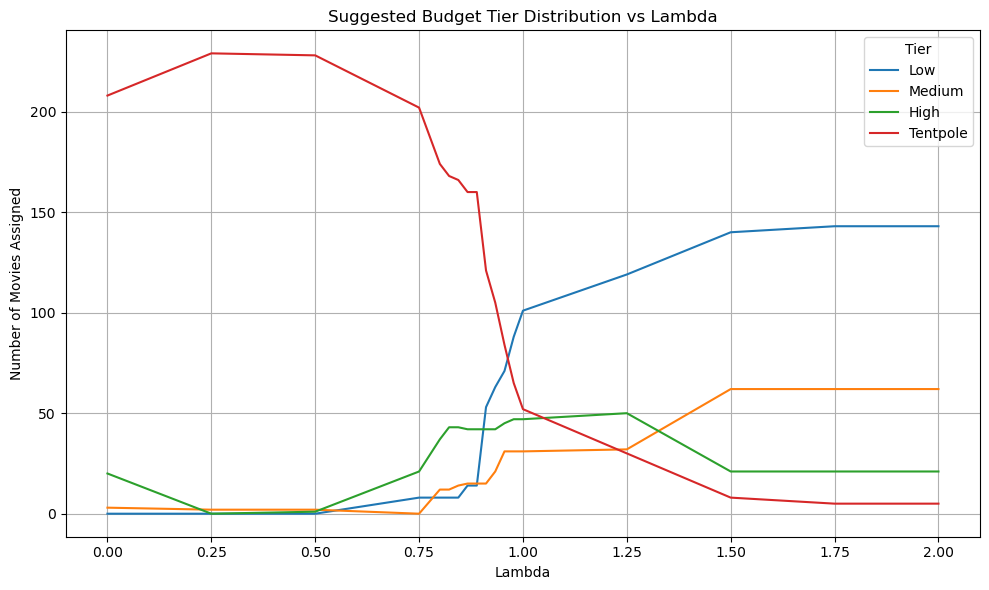

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Step 1: Create lambda sweep
lambda_coarse = np.linspace(0.0, 2.0, 9)  # 0.0, 0.25, ..., 2.0
lambda_fine = np.linspace(0.8, 1.0, int((1.0 - 0.8)/0.02) + 1)  # 0.80, 0.82, ..., 1.00
lambda_values = np.sort(np.unique(np.concatenate((lambda_coarse, lambda_fine))))

# Step 2: Sweep over lambdas
summary = []

for lam in lambda_values:
    results = []

    for idx, test_row in df_test_filtered.iterrows():
        test_features = test_row[feature_cols].values.reshape(1, -1)
        tier_scores = []

        for tier in gmm_models.keys():
            scaler = scalers[tier]
            gmm = gmm_models[tier]

            X_scaled = scaler.transform(test_features)
            cluster_id = gmm.predict(X_scaled)[0]

            tier_df = df_train_val_filtered[df_train_val_filtered["from_budget_category"] == tier]
            y_tier = tier_df["profit"].reset_index(drop=True)
            X_tier = tier_df[feature_cols]
            X_tier_scaled = scaler.transform(X_tier)

            cluster_assignments = gmm.predict(X_tier_scaled)
            cluster_mask = cluster_assignments == cluster_id
            cluster_profits = y_tier[cluster_mask].reset_index(drop=True)

            if len(cluster_profits) > 1:
                avg_profit = cluster_profits.mean()
                std_profit = cluster_profits.std(ddof=1)
                risk_adjusted_score = avg_profit - lam * std_profit
            else:
                risk_adjusted_score = -np.inf

            tier_scores.append({
                "tier": tier,
                "risk_adjusted_score": risk_adjusted_score,
                "avg_profit": avg_profit
            })

        best = max(tier_scores, key=lambda x: x["risk_adjusted_score"])

        results.append({
            "chosen_tier": best["tier"],
            "predicted_profit": best["avg_profit"],
            "actual_profit": test_row["profit"],
            "abs_error": abs(best["avg_profit"] - test_row["profit"])
        })

    df_lambda = pd.DataFrame(results)
    tier_counts = Counter(df_lambda["chosen_tier"])
    mean_abs_error = df_lambda["abs_error"].mean()

    summary.append({
        "lambda": lam,
        "MAE": mean_abs_error,
        **tier_counts
    })

# Step 3: Build DataFrame
df_summary = pd.DataFrame(summary).fillna(0)

print("Lambda sweep and results complete!")

# Step 4: Plot Tier distributions vs lambda
plt.figure(figsize=(10, 6))
tiers = ["low", "medium", "high", "tentpole"]

for tier in tiers:
    if tier in df_summary.columns:
        plt.plot(df_summary["lambda"], df_summary[tier], label=tier.capitalize())

plt.title("Suggested Budget Tier Distribution vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("Number of Movies Assigned")
plt.legend(title="Tier")
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
# Step 1: Compute difference between Low and Tentpole counts
df_summary["low_minus_tentpole"] = df_summary["low"] - df_summary["tentpole"]

# Step 2: Find where the difference changes sign (crossing point)
sign_changes = df_summary["low_minus_tentpole"].diff().apply(lambda x: x != 0)

# Pull only switching points
switch_df = df_summary[sign_changes].copy()

print("\nSwitch points where Low and Tentpole cross:")
print(switch_df[["lambda", "low", "tentpole", "low_minus_tentpole"]])



Switch points where Low and Tentpole cross:
      lambda    low  tentpole  low_minus_tentpole
0   0.000000    0.0       208              -208.0
1   0.250000    0.0       229              -229.0
2   0.500000    0.0       228              -228.0
3   0.750000    8.0       202              -194.0
4   0.800000    8.0       174              -166.0
5   0.822222    8.0       168              -160.0
6   0.844444    8.0       166              -158.0
7   0.866667   14.0       160              -146.0
9   0.911111   53.0       121               -68.0
10  0.933333   63.0       105               -42.0
11  0.955556   71.0        84               -13.0
12  0.977778   88.0        65                23.0
13  1.000000  101.0        52                49.0
14  1.250000  119.0        30                89.0
15  1.500000  140.0         8               132.0
16  1.750000  143.0         5               138.0


In [28]:
# Two points around the crossing
lambda1 = 0.955556
lambda2 = 0.977778

low1 = 71
low2 = 88

tentpole1 = 84
tentpole2 = 65

# Slopes
m_low = (low2 - low1) / (lambda2 - lambda1)
m_tentpole = (tentpole2 - tentpole1) / (lambda2 - lambda1)

# Solve for lambda where Low = Tentpole
lambda_cross = (tentpole1 - low1) / (m_low - m_tentpole) + lambda1

print(f"Exact lambda where Low = Tentpole: {lambda_cross:.6f}")


Exact lambda where Low = Tentpole: 0.963581


In [29]:
# Check outcomes for the tracked Poster 2 movies using SUGGESTED TIERS

target_titles = [
    "Love Actually", 
    "Talladega Nights: The Ballad of Ricky Bobby", 
    "Scarface", 
    "Erin Brockovich", 
    "Man on the Moon", 
    "Nope"
]

for title in target_titles:
    # Locate movie in the test set
    row = df_test_filtered[df_test_filtered["from_title"] == title]
    
    if row.empty:
        print(f"\n=== {title} ===")
        print("  Movie not found in df_test_filtered!")
        continue
    
    idx = row.index.values[0]

    # Lookup suggested tier
    suggested_row = df_suggested_tiers[df_suggested_tiers["index"] == idx]
    if suggested_row.empty:
        print(f"\n=== {title} ===")
        print("  No suggested tier found!")
        continue

    suggested_tier = suggested_row["suggested_tier"].values[0]

    # Now: find the GMM model and cluster for this suggested tier
    test_features = row[feature_cols].values.reshape(1, -1)
    scaler = scalers[suggested_tier]
    gmm = gmm_models[suggested_tier]

    X_scaled = scaler.transform(test_features)
    cluster_id = gmm.predict(X_scaled)[0]

    # Get cluster profit distribution
    tier_df = df_train_val_filtered[df_train_val_filtered["from_budget_category"] == suggested_tier]
    y_tier = tier_df["profit"].reset_index(drop=True)
    X_tier = tier_df[feature_cols]
    X_tier_scaled = scaler.transform(X_tier)

    cluster_assignments = gmm.predict(X_tier_scaled)
    cluster_mask = cluster_assignments == cluster_id
    cluster_profits = y_tier[cluster_mask].reset_index(drop=True)

    if len(cluster_profits) > 1:
        avg_profit = cluster_profits.mean()
        std_profit = cluster_profits.std(ddof=1)
        n = len(cluster_profits)
        from scipy.stats import t
        profit_ci = t.interval(
            confidence=0.95,
            df=n - 1,
            loc=avg_profit,
            scale=std_profit / np.sqrt(n)
        )
    else:
        avg_profit = np.nan
        profit_ci = (np.nan, np.nan)

    actual_profit = row["profit"].values[0]

    # Print output
    print(f"\n=== {title} ===")
    print(f"  Suggested Tier: {suggested_tier}")
    print(f"  Actual Profit: ${actual_profit:,.2f}")
    print(f"  Predicted Profit (Cluster Avg): ${avg_profit:,.2f}")
    print(f"  Profit CI: ({profit_ci[0]:,.2f}, {profit_ci[1]:,.2f})")
    
    if pd.isnull(profit_ci[0]) or pd.isnull(profit_ci[1]):
        print("  Outcome: No CI available")
    elif profit_ci[0] > actual_profit:
        print("  Outcome: Model Upgrade (model predicted better)")
    elif profit_ci[1] < actual_profit:
        print("  Outcome: Model Downgrade (model predicted worse)")
    else:
        print("  Outcome: Match (model reasonable)")



=== Love Actually ===
  Suggested Tier: high
  Actual Profit: $574,786,080.02
  Predicted Profit (Cluster Avg): $143,948,986.10
  Profit CI: (64,162,764.20, 223,735,208.00)
  Outcome: Model Downgrade (model predicted worse)

=== Talladega Nights: The Ballad of Ricky Bobby ===
  Suggested Tier: medium
  Actual Profit: $206,736,963.59
  Predicted Profit (Cluster Avg): $51,941,820.60
  Profit CI: (30,915,536.86, 72,968,104.34)
  Outcome: Model Downgrade (model predicted worse)

=== Scarface ===
  Suggested Tier: high
  Actual Profit: $383,939,533.49
  Predicted Profit (Cluster Avg): $297,710,957.81
  Profit CI: (73,325,600.98, 522,096,314.65)
  Outcome: Match (model reasonable)

=== Erin Brockovich ===
  Suggested Tier: tentpole
  Actual Profit: $639,575,234.14
  Predicted Profit (Cluster Avg): $400,659,588.61
  Profit CI: (300,933,064.81, 500,386,112.40)
  Outcome: Model Downgrade (model predicted worse)

=== Man on the Moon ===
  Suggested Tier: tentpole
  Actual Profit: $-115,623,027.

### QUERY GRAPH

In [30]:
tracked_recos = {}

for title in target_titles:
    # Locate movie in test set
    row = df_test_filtered[df_test_filtered["from_title"] == title]
    
    if row.empty:
        print(f"\n=== {title} ===")
        print("  Movie not found!")
        continue

    idx = row.index.values[0]

    # Suggested tier
    suggested_row = df_suggested_tiers[df_suggested_tiers["index"] == idx]
    if suggested_row.empty:
        print(f"\n=== {title} ===")
        print("  No suggested tier found!")
        continue

    suggested_tier = suggested_row["suggested_tier"].values[0]

    # Project into suggested tier's GMM
    test_features = row[feature_cols].values.reshape(1, -1)
    scaler = scalers[suggested_tier]
    gmm = gmm_models[suggested_tier]

    X_scaled = scaler.transform(test_features)
    cluster_id = gmm.predict(X_scaled)[0]

    # Find matching training+validation movies
    tier_df = df_train_val_filtered[df_train_val_filtered["from_budget_category"] == suggested_tier]
    X_tier = tier_df[feature_cols]
    X_tier_scaled = scaler.transform(X_tier)

    cluster_assignments = gmm.predict(X_tier_scaled)
    tier_df["assigned_cluster"] = cluster_assignments

    cluster_movies = tier_df[tier_df["assigned_cluster"] == cluster_id]

    tracked_recos[title] = cluster_movies

    print(f"\n=== {title} ===")
    print(f"  Suggested Tier: {suggested_tier}")
    print(f"  Cluster ID: {cluster_id}")
    print(f"  Found {len(cluster_movies)} movies in same cluster.")

print("\nCluster assignment and matching movies complete!")



=== Love Actually ===
  Suggested Tier: high
  Cluster ID: 18
  Found 27 movies in same cluster.

=== Talladega Nights: The Ballad of Ricky Bobby ===
  Suggested Tier: medium
  Cluster ID: 21
  Found 76 movies in same cluster.

=== Scarface ===
  Suggested Tier: high
  Cluster ID: 16
  Found 6 movies in same cluster.

=== Erin Brockovich ===
  Suggested Tier: tentpole
  Cluster ID: 12
  Found 71 movies in same cluster.

=== Man on the Moon ===
  Suggested Tier: tentpole
  Cluster ID: 8
  Found 108 movies in same cluster.

=== Nope ===
  Suggested Tier: tentpole
  Cluster ID: 12
  Found 71 movies in same cluster.

Cluster assignment and matching movies complete!


C:\Users\Joe\AppData\Local\Temp\ipykernel_10096\364454559.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tier_df["assigned_cluster"] = cluster_assignments
C:\Users\Joe\AppData\Local\Temp\ipykernel_10096\364454559.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tier_df["assigned_cluster"] = cluster_assignments
C:\Users\Joe\AppData\Local\Temp\ipykernel_10096\364454559.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [31]:
# Build a dictionary: title → list of from_tconsts
query_movie_ids = {}

for title, df_cluster in tracked_recos.items():
    movie_ids = df_cluster["from_tconst"].tolist()
    query_movie_ids[title] = movie_ids

print("Movie ID lists ready for graph queries!")

# Print neighboring movies for each tracked movie
for title, df_cluster in tracked_recos.items():
    print(f"\n=== Neighbors for {title} ===")

    # Get the actual test movie row (by title match)
    test_movie_row = df_test_filtered[df_test_filtered["from_title"] == title]
    if test_movie_row.empty:
        print("  Test movie not found!")
        continue

    test_movie_tconst = test_movie_row.iloc[0]["from_tconst"]

    # Exclude the test movie itself
    neighbors_df = df_cluster[df_cluster["from_tconst"] != test_movie_tconst]

    # Pick nice columns to display
    cols_to_show = ["from_title", "from_year", "profit", "from_budget_category"]

    if not set(cols_to_show).issubset(neighbors_df.columns):
        print("  Columns missing!")
        continue

    display_df = neighbors_df[cols_to_show].sort_values(by="profit", ascending=False)

    for idx, row in display_df.iterrows():
        print(f"  {row['from_title']} ({int(row['from_year'])}) — Profit: ${row['profit']:,.0f} — Budget Tier: {row['from_budget_category']}")


Movie ID lists ready for graph queries!

=== Neighbors for Love Actually ===
  Airport (1970) — Profit: $710,624,363 — Budget Tier: high
  Aliens (1986) — Profit: $458,210,798 — Budget Tier: high
  A Beautiful Mind (2001) — Profit: $445,267,519 — Budget Tier: high
  A Few Good Men (1992) — Profit: $441,394,788 — Budget Tier: high
  The Hunt for Red October (1990) — Profit: $397,517,547 — Budget Tier: high
  American Hustle (2013) — Profit: $276,207,506 — Budget Tier: high
  A Perfect World (1993) — Profit: $221,620,624 — Budget Tier: high
  L.A. Confidential (1997) — Profit: $173,171,240 — Budget Tier: high
  Firefox (1982) — Profit: $166,402,025 — Budget Tier: high
  Unbroken (2014) — Profit: $126,650,264 — Budget Tier: high
  Finding Forrester (2000) — Profit: $65,647,179 — Budget Tier: high
  The Natural (1984) — Profit: $58,652,936 — Budget Tier: high
  The Woman King (2022) — Profit: $49,247,081 — Budget Tier: high
  Bugsy (1991) — Profit: $42,761,225 — Budget Tier: high
  The Lov

In [32]:
# Build a dictionary: title → list of from_tconsts (excluding test movie itself)
query_movie_ids = {}

for title, df_cluster in tracked_recos.items():
    # Get test movie's tconst
    test_movie_row = df_test_filtered[df_test_filtered["from_title"] == title]
    if test_movie_row.empty:
        print(f"  Test movie '{title}' not found!")
        continue
    test_movie_tconst = test_movie_row.iloc[0]["from_tconst"]

    # Exclude the test movie itself
    neighbors_df = df_cluster[df_cluster["from_tconst"] != test_movie_tconst]

    # Collect tconsts
    movie_ids = neighbors_df["from_tconst"].tolist()
    query_movie_ids[title] = movie_ids

print("\n=== TCONST lists per tracked movie ===\n")
for title, tconst_list in query_movie_ids.items():
    tconst_string = ", ".join(f'"{t}"' for t in tconst_list)
    print(f"\n{title} — {len(tconst_list)} neighbors:")
    print(tconst_string)


=== TCONST lists per tracked movie ===


Love Actually — 26 neighbors:
"tt0084917", "tt0098575", "tt0065377", "tt0101889", "tt0380510", "tt0126916", "tt0101516", "tt0294870", "tt0083943", "tt1809398", "tt0104257", "tt0107808", "tt0119978", "tt0119488", "tt1800241", "tt8093700", "tt0268978", "tt0298814", "tt24176060", "tt0090605", "tt0087781", "tt1014763", "tt0099810", "tt0181536", "tt11138512", "tt0100594"

Talladega Nights: The Ballad of Ricky Bobby — 76 neighbors:
"tt0475394", "tt0103247", "tt0098051", "tt0086450", "tt1464174", "tt0151738", "tt11291274", "tt0116367", "tt1013860", "tt1563738", "tt0089360", "tt2978462", "tt0989757", "tt0815244", "tt1130080", "tt0087277", "tt1016075", "tt1245492", "tt0096320", "tt0780536", "tt0089348", "tt0105414", "tt0465142", "tt0120890", "tt0120877", "tt0297884", "tt1385867", "tt0097351", "tt0103035", "tt0391304", "tt3387520", "tt0109686", "tt9764362", "tt0085959", "tt0132477", "tt0116329", "tt0441774", "tt3231054", "tt0099731", "tt0355702", "tt0093

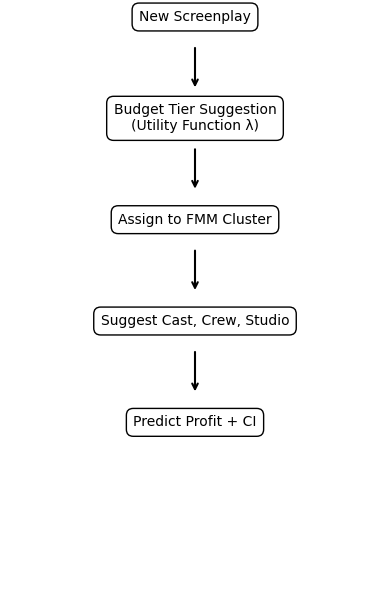

In [33]:
import matplotlib.pyplot as plt

# Steps
steps = [
    "New Screenplay",
    "Budget Tier Suggestion\n(Utility Function λ)",
    "Assign to FMM Cluster",
    "Suggest Cast, Crew, Studio",
    "Predict Profit + CI"
]

# Create the plot
fig, ax = plt.subplots(figsize=(4, 6))
ax.axis("off")

# Draw steps
for i, step in enumerate(steps):
    ax.text(0.5, 1 - i * 0.18, step,
            ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.5", edgecolor='black', facecolor='white'))

# Draw arrows
for i in range(len(steps) - 1):
    ax.annotate("", xy=(0.5, 1 - (i+1) * 0.18 + 0.05), xytext=(0.5, 1 - i * 0.18 - 0.05),
                arrowprops=dict(arrowstyle="->", lw=1.5))

plt.tight_layout()
plt.show()


In [41]:
# All budget tiers to evaluate
budget_tiers = ["low", "medium", "high", "tentpole"]

# The four test movies
target_movies = [
    "Nope",
    "Scarface",
    "Love Actually",
    "Talladega Nights: The Ballad of Ricky Bobby"
]

# Dictionary to hold results: movie -> tier -> {cluster_id, tconsts}
full_cluster_tconsts = {}

for title in target_movies:
    test_index = df_test_filtered[df_test_filtered["from_title"] == title].index[0]
    test_row = df_test_filtered.loc[test_index]
    test_features = test_row[feature_cols].values.reshape(1, -1)

    full_cluster_tconsts[title] = {}

    for tier in budget_tiers:
        # Predict cluster assignment for this tier
        X_scaled = scalers[tier].transform(test_features)
        cluster_id = gmm_models[tier].predict(X_scaled)[0]

        # Get cluster members from train+val
        tier_df = df_train_val_filtered[df_train_val_filtered["from_budget_category"] == tier]
        X_tier = tier_df[feature_cols]
        X_tier_scaled = scalers[tier].transform(X_tier)
        cluster_assignments = gmm_models[tier].predict(X_tier_scaled)

        matching_indices = cluster_assignments == cluster_id
        cluster_df = tier_df[matching_indices]
        tconst_list = cluster_df["from_tconst"].tolist()

        full_cluster_tconsts[title][tier] = {
            "cluster_id": cluster_id,
            "tconsts": tconst_list
        }

        # Print results
        print(f"\n--- {title} | Tier: {tier} ---")
        print(f"Cluster ID: {cluster_id}")
        print("TCONSTs:")
        for t in tconst_list:
            print(t)



--- Nope | Tier: low ---
Cluster ID: 11
TCONSTs:
tt0120655
tt0077869
tt21064584
tt0082766
tt9243804
tt4540710
tt0071877
tt5726616
tt2357129
tt0102536
tt10168670
tt1935179
tt0247425
tt7599146

--- Nope | Tier: medium ---
Cluster ID: 16
TCONSTs:
tt0414387
tt1521197
tt0100168
tt5776858
tt0878804
tt0387131
tt0088846
tt0200669
tt0482572
tt0071315
tt0379889
tt1586752
tt6966692
tt1980209
tt1895587
tt0478311
tt0097165
tt11198810
tt6823368
tt0405159
tt0074292
tt0119843
tt1013753
tt0109642
tt1175491
tt0103074
tt0081696
tt1596363
tt0105695
tt0070735
tt17351924
tt22866358
tt0419887
tt0066769
tt1837703
tt3783958
tt10016180
tt4960748
tt3569230
tt0120783
tt0091187
tt12226632
tt5177114
tt8722346
tt8946378
tt0070666
tt1020072

--- Nope | Tier: high ---
Cluster ID: 4
TCONSTs:
tt4572514
tt6343314
tt0086190
tt0108358
tt0448115
tt1027718
tt1535109
tt3513548
tt0119311
tt0120744
tt1727824
tt0469903
tt0790724
tt0080455
tt1538403
tt0106977
tt0245844
tt4046784
tt0110322
tt16426418
tt0238112
tt0090022
tt3065204

### LAMBDA SWEEP

In [45]:
import numpy as np

# Lambda grid from 0.0 to 2.0
lambda_grid = np.round(np.linspace(0.0, 2.0, 201), 4)

# Four test movies
target_movies = [
    "Nope",
    "Scarface",
    "Love Actually",
    "Talladega Nights: The Ballad of Ricky Bobby"
]

# Output: movie → tier → list of lambda values
lambda_ranges_by_movie = {}

for title in target_movies:
    test_index = df_test_filtered[df_test_filtered["from_title"] == title].index[0]
    test_row = df_test_filtered.loc[test_index]
    test_features = test_row[feature_cols].values.reshape(1, -1)

    for lamb in lambda_grid:
        tier_scores = []

        for tier in budget_tiers:
            scaler = scalers[tier]
            gmm = gmm_models[tier]

            X_scaled = scaler.transform(test_features)
            cluster_id = gmm.predict(X_scaled)[0]

            tier_df = df_train_val_filtered[df_train_val_filtered["from_budget_category"] == tier]
            X_tier = tier_df[feature_cols]
            y_tier = tier_df["profit"]
            X_scaled_tier = scaler.transform(X_tier)
            cluster_assignments = gmm.predict(X_scaled_tier)
            mask = cluster_assignments == cluster_id
            cluster_profits = y_tier[mask].reset_index(drop=True)

            if len(cluster_profits) > 1:
                avg = cluster_profits.mean()
                std = cluster_profits.std(ddof=1)
                score = avg - lamb * std
            else:
                score = -np.inf

            tier_scores.append((tier, score))

        best_tier = max(tier_scores, key=lambda x: x[1])[0]

        if title not in lambda_ranges_by_movie:
            lambda_ranges_by_movie[title] = {}
        if best_tier not in lambda_ranges_by_movie[title]:
            lambda_ranges_by_movie[title][best_tier] = []

        lambda_ranges_by_movie[title][best_tier].append(lamb)

print("✅ Done — lambda_ranges_by_movie now contains sweep results for the 4 target movies.")

✅ Done — lambda_ranges_by_movie now contains sweep results for the 4 target movies.


In [47]:
lambda_bounds_by_movie = {}

for movie, tier_dict in lambda_ranges_by_movie.items():
    lambda_bounds_by_movie[movie] = {}
    for tier, lambdas in tier_dict.items():
        lower = min(lambdas)
        upper = max(lambdas)
        lambda_bounds_by_movie[movie][tier] = (lower, upper)
lambda_bounds_by_movie

{'Nope': {'tentpole': (0.0, 0.98), 'low': (0.99, 2.0)},
 'Scarface': {'medium': (0.0, 0.2),
  'tentpole': (0.21, 0.46),
  'high': (0.47, 1.45),
  'low': (1.46, 2.0)},
 'Love Actually': {'tentpole': (0.0, 0.82),
  'high': (0.83, 1.24),
  'low': (1.25, 2.0)},
 'Talladega Nights: The Ballad of Ricky Bobby': {'tentpole': (0.0, 0.94),
  'medium': (0.95, 2.0)}}

In [66]:
from scipy.stats import t

# Assume you already have this from earlier
cluster_ids_by_movie = {
    "Nope": {"low": 11, "medium": 16, "high": 4, "tentpole": 12},
    "Scarface": {"low": 6, "medium": 4, "high": 16, "tentpole": 19},
    "Love Actually": {"low": 2, "medium": 0, "high": 18, "tentpole": 7},
    "Talladega Nights: The Ballad of Ricky Bobby": {"low": 0, "medium": 21, "high": 8, "tentpole": 18}
}

# Use the min–max lambda bounds you just computed
# Format: lambda_bounds_by_movie[movie][tier] = (lower, upper)

# Prep output
analysis_by_movie = {}

for movie, tier_cluster_map in cluster_ids_by_movie.items():
    analysis_by_movie[movie] = {}

    for tier, cluster_id in tier_cluster_map.items():
        # Get all training+val movies in this tier
        tier_df = df_train_val_filtered[df_train_val_filtered["from_budget_category"] == tier]
        X_tier = tier_df[feature_cols]
        X_scaled = scalers[tier].transform(X_tier)
        cluster_assignments = gmm_models[tier].predict(X_scaled)

        # Filter for the matching cluster
        mask = cluster_assignments == cluster_id
        cluster_df = tier_df[mask]
        profits = cluster_df["profit"]

        # Profit + CI
        avg_profit = profits.mean()
        std_profit = profits.std(ddof=1)
        n = len(profits)
        if n > 1:
            ci = t.interval(0.95, df=n - 1, loc=avg_profit, scale=std_profit / (n**0.5))
            ci_formatted = (f"${ci[0]/1_000_000:.1f}M", f"${ci[1]/1_000_000:.1f}M") if None not in ci else (None, None)
        else:
            ci_formatted = (None, None)

        # Genre breakdowns (remove prefixes + filter zeroes)
        genre_cols = [col for col in tier_df.columns if col.startswith("genres_")]
        subgenre_cols = [col for col in tier_df.columns if col.startswith("subgenres_")]

        genre_counts = tier_df.loc[mask, genre_cols].sum().sort_values(ascending=False)
        subgenre_counts = tier_df.loc[mask, subgenre_cols].sum().sort_values(ascending=False)

        # Strip prefixes from keys
        genres_clean = {col.replace("genres_", ""): int(val) for col, val in genre_counts[genre_counts > 0].items()}
        subgenres_clean = {col.replace("subgenres_", ""): int(val) for col, val in subgenre_counts[subgenre_counts > 0].items()}

        # Lambda range from your dict (use None if not found)
        lambda_range = None
        if movie in lambda_bounds_by_movie and tier in lambda_bounds_by_movie[movie]:
            lambda_range = lambda_bounds_by_movie[movie][tier]

        # Final output
        analysis_by_movie[movie][tier] = {
            "cluster_id": cluster_id,
            "predicted_profit": f"${avg_profit / 1_000_000:.1f}M",
            "confidence_interval": ci_formatted,
            "lambda_range": lambda_range,
            "genres": genres_clean,
            "subgenres": subgenres_clean,
            "movie_titles": cluster_df["from_title"].tolist()
        }

print("✅ analysis_by_movie now holds full tier breakdowns with clean genre/subgenre labels.")


✅ analysis_by_movie now holds full tier breakdowns with clean genre/subgenre labels.


In [67]:
analysis_by_movie["Nope"]["low"]

{'cluster_id': 11,
 'predicted_profit': '$62.2M',
 'confidence_interval': ('$17.8M', '$106.5M'),
 'lambda_range': (0.99, 2.0),
 'genres': {'Biography': 4,
  'Adventure': 4,
  'Crime': 3,
  'Comedy': 2,
  'Fantasy': 2,
  'Romance': 2,
  'Horror': 1,
  'Mystery': 1,
  'Animation': 1,
  'Sport': 1},
 'subgenres': {'docudrama': 4,
  'coming-of-age-drama': 3,
  'dark-comedy': 2,
  'epic-adventure': 2,
  'sword-and-sorcery-fantasy': 2,
  'tragedy-drama': 2,
  'showbiz-drama': 1,
  'road-trip-adventure': 1,
  'quirky-comedy': 1,
  'suspense-mystery': 1,
  'quest-adventure': 1,
  'steamy-romance': 1,
  'teen-adventure': 1,
  'psychological-drama': 1,
  'teen-drama': 1,
  'satire-comedy': 1,
  'political-drama': 1,
  'tragic-romance': 1,
  'true-crime': 1,
  'epic-drama': 1,
  'whodunnit-mystery': 1,
  'epic-fantasy': 1,
  'dark-fantasy': 1},
 'movie_titles': ['Dogma',
  'The Lord of the Rings',
  'The Iron Claw',
  'Mommie Dearest',
  'The Green Knight',
  'Miss Sloane',
  'Murder on the Orien

In [70]:
for movie in analysis_by_movie:
    # Pull true genres and subgenres from test set
    test_row = df_test_filtered[df_test_filtered["from_title"] == movie].iloc[0]
    true_genres = [g.replace("genres_", "") for g in df_test_filtered.columns if g.startswith("genres_") and test_row[g] == 1]
    true_subgenres = [s.replace("subgenres_", "") for s in df_test_filtered.columns if s.startswith("subgenres_") and test_row[s] == 1]

    for tier in analysis_by_movie[movie]:
        cluster_titles = analysis_by_movie[movie][tier]["movie_titles"]
        cluster_df = df_train_val_filtered[df_train_val_filtered["from_title"].isin(cluster_titles)]

        # Only include genres/subgenres that are actually used in the cluster
        active_genres = [g for g in true_genres if f"genres_{g}" in cluster_df.columns and cluster_df[f"genres_{g}"].sum() > 0]
        active_subgenres = [s for s in true_subgenres if f"subgenres_{s}" in cluster_df.columns and cluster_df[f"subgenres_{s}"].sum() > 0]

        # Match by genre
        matched_by_genre = {
            g: cluster_df[cluster_df[f"genres_{g}"] == 1]["from_title"].drop_duplicates().tolist()
            for g in active_genres
        }

        # Match by subgenre
        matched_by_subgenre = {
            s: cluster_df[cluster_df[f"subgenres_{s}"] == 1]["from_title"].drop_duplicates().tolist()
            for s in active_subgenres
        }

        # Add to analysis_by_movie
        analysis_by_movie[movie][tier]["matching_by_genre"] = matched_by_genre
        analysis_by_movie[movie][tier]["matching_by_subgenre"] = matched_by_subgenre


# Example output check
from pprint import pprint
pprint(analysis_by_movie["Nope"]["low"])

{'cluster_id': 11,
 'confidence_interval': ('$17.8M', '$106.5M'),
 'genres': {'Adventure': 4,
            'Animation': 1,
            'Biography': 4,
            'Comedy': 2,
            'Crime': 3,
            'Fantasy': 2,
            'Horror': 1,
            'Mystery': 1,
            'Romance': 2,
            'Sport': 1},
 'lambda_range': (0.99, 2.0),
 'matching_by_genre': {'Horror': ['Bones and All'],
                       'Mystery': ['Murder on the Orient Express']},
 'matching_by_subgenre': {},
 'movie_titles': ['Dogma',
                  'The Lord of the Rings',
                  'The Iron Claw',
                  'Mommie Dearest',
                  'The Green Knight',
                  'Miss Sloane',
                  'Murder on the Orient Express',
                  'Call Me by Your Name',
                  'Jobs',
                  'Night on Earth',
                  'Bones and All',
                  'Mud',
                  'In the Bedroom',
                  'Sound of Fre

In [76]:
import matplotlib.pyplot as plt
import os

# Create output folder
output_dir = "../plots/genres_subgenres_per_tier"
os.makedirs(output_dir, exist_ok=True)

for movie, tiers in analysis_by_movie.items():
    # Get true genre/subgenre labels
    test_row = df_test_filtered[df_test_filtered["from_title"] == movie].iloc[0]
    true_genres = [g.replace("genres_", "") for g in df_test_filtered.columns if g.startswith("genres_") and test_row[g] == 1]
    true_subgenres = [s.replace("subgenres_", "") for s in df_test_filtered.columns if s.startswith("subgenres_") and test_row[s] == 1]
    true_genre_str = ", ".join(true_genres)
    true_subgenre_str = ", ".join(true_subgenres)

    for tier, info in tiers.items():
        genre_data = info["genres"]
        subgenre_data = info["subgenres"]
        lam_range = info["lambda_range"]
        lam_str = f"λ ∈ [{lam_range[0]:.2f}, {lam_range[1]:.2f}]" if lam_range else "λ range: N/A"

        # --- Genre Chart ---
        if genre_data:
            sorted_genres = dict(sorted(genre_data.items(), key=lambda x: x[1], reverse=True))
            labels = list(sorted_genres.keys())
            values = list(sorted_genres.values())
            colors = ["black" if label in true_genres else "0.5" for label in labels]

            plt.figure(figsize=(10, max(2, len(labels) * 0.4)))
            plt.barh(labels, values, color=colors)
            plt.xlabel("Count")
            plt.title(f"{movie} — {tier.title()} Tier — {lam_str}\nTrue Genres: {true_genre_str}")
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.savefig(f"{output_dir}/{movie}_{tier}_genres.png")
            plt.close()

        # --- Subgenre Chart ---
        if subgenre_data:
            sorted_subgenres = dict(sorted(subgenre_data.items(), key=lambda x: x[1], reverse=True))
            labels = list(sorted_subgenres.keys())
            values = list(sorted_subgenres.values())
            colors = ["black" if label in true_subgenres else "0.5" for label in labels]

            plt.figure(figsize=(10, max(2, len(labels) * 0.4)))
            plt.barh(labels, values, color=colors)
            plt.xlabel("Count")
            plt.title(f"{movie} — {tier.title()} Tier — {lam_str}\nTrue Subgenres: {true_subgenre_str}")
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.savefig(f"{output_dir}/{movie}_{tier}_subgenres.png")
            plt.close()
